# CNN model (from "Fast Solar Image Classification Using Deep Learning and its Importance for Automation in Solar Physics" - Convolutional neural network)

## 0. Load modules


In [1]:
# Main libraries used all the time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Operating system libraries
import os
import sys

# Machine learning libraries
import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

import torch.nn as nn
import torch.optim as optim
import argparse
from tqdm import tqdm


from torchvision.transforms import v2 # library to define the transforms

#!pip install torcheval  # needs to run on google colab, on local machine you can just "pip install torcheval" in the terminal
from torcheval.metrics.functional import multiclass_f1_score

# Visualization and debugging
from sklearn.metrics import confusion_matrix
import seaborn as sns
#!pip install sunpy
from sunpy.visualization.colormaps import color_tables as ct


## 1. Import the data, create the dataset, define the Dataloaders

### 1.1 Declare data path

In [2]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Carlos
    #folder0_path = '/content/drive/My Drive/solar_jets/data0'
    #folder0_test_path = '/content/drive/My Drive/solar_jets/data0_test'
    #folder1_path = '/content/drive/My Drive/solar_jets/data1'
    #folder1_test_path = '/content/drive/My Drive/solar_jets/data1_test'

    # Julie
    #folder0_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0'
    #folder1_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1'

    #folder0_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_val'
    #folder1_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'


    #Adrien
    folder0_path = '/content/drive/My Drive/Machine Learning/Projet/data0'
    folder1_path = '/content/drive/My Drive/Machine Learning/Projet/data1'
    folder0_test_path = '/content/drive/My Drive/Machine Learning/Projet/data0_test'
    folder1_test_path = '/content/drive/My Drive/Machine Learning/Projet/data1_test'
    folder0_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data0_val'
    folder1_valid_path = '/content/drive/My Drive/Machine Learning/Projet/data1_val'
else:
    # For local environments like VS Code
    folder0_path = './data0'
    folder1_path = './data1'
    folder0_test_path = './data0_test'
    folder1_test_path = './data1_test'
    folder0_valid_path = './data0_val'
    folder1_valid_path = './data1_val'

### 1.2 Declare the class and the transforms

In [3]:
class NPZDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir

        # in self.files, only add f if it has 30 samples
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = transform

    # Check if the file has 30 samples, if not, don't include it in self.files (see above)
    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']

        # Rearrange dimensions to (30, 166, 166) for PyTorch (insted of (166, 166, 30))
        data = np.moveaxis(data, -1, 0)

        # assign label 1 if data is from data1, 0 if from data0
        label = 1.0 if 'data1' in self.data_dir else 0.0
        return torch.from_numpy(data).float(), label

In [30]:
mean = 51.6644
std = 62.7087

train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()

    #v2.RandomResizedCrop(size=(55, 55)),                                          # weird pixelized img, we don't see the jet well sometimes
    v2.RandomAffine(degrees=(-90,90), translate=(0.3, 0.3), scale=(0.8, 1.2)),    # good+useful if future sequences are not well cut out, moves the jet around the img
    #v2.RandomHorizontalFlip(p=0.4),                                               # just flips the image, no big difference
    #v2.RandomVerticalFlip(p=0.4),                                                 # same
    #v2.RandomRotation(degrees=(-90,90)),                                          # rotation, jet stays at the center of the image
    #v2.RandomZoomOut(side_range=(1,3), p=0.4),                                    # makes the jet smaller and not necessarely centered

    v2.Normalize((mean,), (std,)),
    # add other transforms if needed
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()
    v2.Normalize((mean,), (std,)),
])

### 1.3 Get the data, declare the Dataloaders

In [31]:
train_data1 = NPZDataset(folder1_path, transform=train_transform)
train_data0 = NPZDataset(folder0_path, transform=train_transform)
train_data = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, transform=test_transform)
test_data0 = NPZDataset(folder0_test_path, transform=test_transform)
test_data = torch.utils.data.ConcatDataset([test_data1, test_data0])

valid_data1 = NPZDataset(folder1_valid_path, transform=test_transform) #We can keep the same transforms as the test one
valid_data0 = NPZDataset(folder0_valid_path, transform=test_transform)
valid_data = torch.utils.data.ConcatDataset([valid_data1, valid_data0])

Visualize transforms: shows 5 images (10-15 of a sequence) of a chosen sequence in the data. The transform shown is the train_transform defined 2 cells above

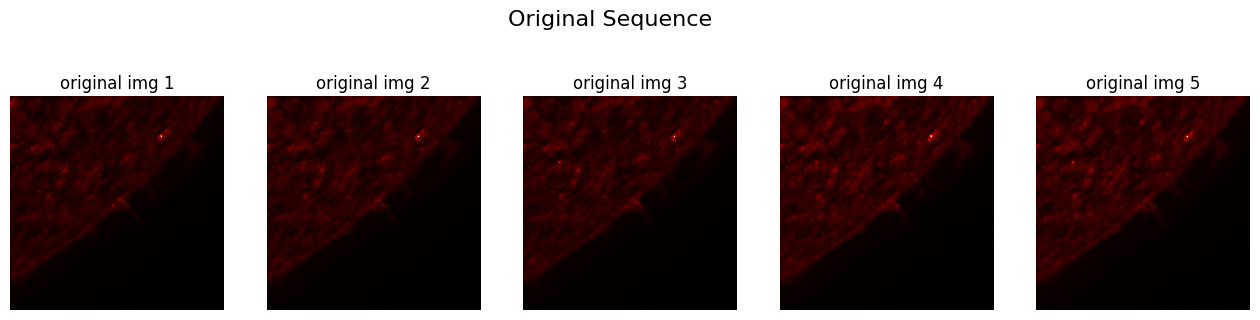

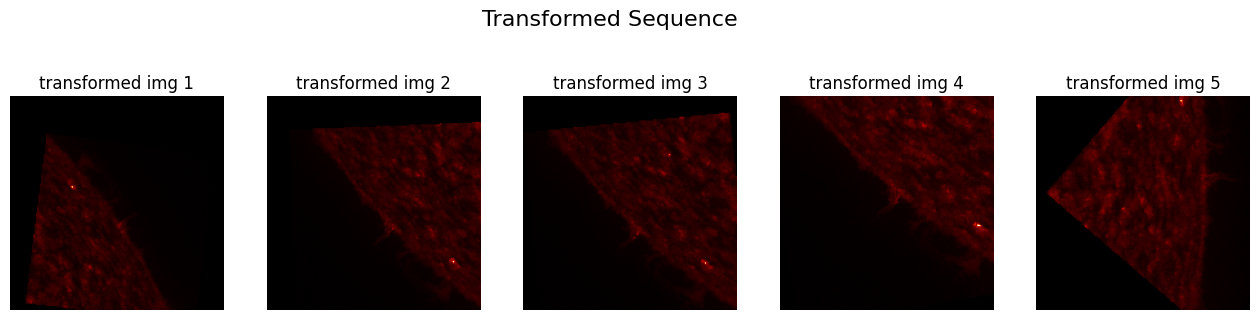

In [32]:
idx = 33 # index of image to visualize
sample_sequence, _ = train_data[idx]
original_sequence = np.moveaxis(sample_sequence.numpy(), 0, -1)  # Move axes back for visualization

# Display the original sequence

plt.figure(figsize=(16, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(original_sequence[:, :, 10+i], cmap='sdoaia304')
    plt.title(f'original img {i + 1}')
    plt.axis('off')

plt.suptitle('Original Sequence', fontsize=16)

# Plot the transformed sequence

plt.figure(figsize=(16, 4))
i = 0

for image in sample_sequence[10:15]:
    plt.subplot(1, 5, i + 1)
    trans = train_transform(image)
    plt.imshow(trans.squeeze(), cmap='sdoaia304')
    plt.title(f'transformed img {i + 1}')
    plt.axis('off')
    i += 1

plt.suptitle('Transformed Sequence', fontsize=16)
plt.show()

## 2. Define the CNN

In [33]:
import torch
import torch.nn as nn
from torch.nn.init import kaiming_normal_

class CNN_lstm(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # hidden_size is an hyperparameter to be adjusted
        # try augmenting num_layers
        self.lstm = nn.LSTM(input_size=12800, hidden_size=512, num_layers=1, batch_first=True)
        
        self.classifier = nn.Sequential(
            nn.Linear(512,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,2)
        )

        for m in self.modules():
            if not CNN:
                kaiming_normal_(m.weight,nonlinearity="relu")#Kaiming to initialize the weights

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        lstm_out, _ = self.lstm(out)
        out = self.classifier(lstm_out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

## 3. Define the training and validation functions

In [34]:
def train_epoch(model,device,data_loader,optimizer,epoch,criterion,scheduler):
    metrics="yes"
    model.train()

    for i, (images, labels) in tqdm(enumerate(data_loader),desc="Epoch no."+str(epoch)): #here the images are the pytorch tensor and labels are long 1 or 0
        images, labels = images.to(device), labels.long().to(device) #Give data and label to device (model already done above)
        optimizer.zero_grad() #must zero the gradients in the optimiser since backward() accumulates gradients and this stops mixing of values between batches
        output = model(images) #feeds the data through the network
        loss = criterion(output,labels) #finds the distance in the loss space between predicted values and actual values
        loss.backward() #backpropagation of the loss
        optimizer.step()

        #Metrics
        if metrics=="yes":
          loss_history_train.append(loss.item())

          pred = output.argmax(dim=1, keepdim=True)
          correct = pred.eq(labels.view_as(pred)).sum().item()
          accuracy_float = correct / len(images)
          acc_history_train.append(accuracy_float)

    scheduler.step()
    lr_history_train.append(scheduler.get_last_lr()[0])

In [35]:
def validate(model,device,data_loader,epoch,criterion):
    model.eval()
    total, correct = 0, 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.long().to(device)
            output = model(images)
            _, predicted = torch.max(output.data,1) #gives the max output index (that is our label)

            #Metrics
            total += labels.size(0)
            correct += (predicted == labels).sum()

            test_loss += criterion(output, labels).item() * len(images)
    print("Test Accuracy of the model on the test images: %f %% on epoch %d" % (100 * correct / total, epoch))

    #Metrics
    acc_history_test.append((correct / total).cpu().detach().numpy())

    test_loss /= len(data_loader.dataset)
    loss_history_test.append(test_loss)

In [36]:
#Model
model = CNN_lstm() #creates an instance of the CNN

#Hyperparameters
num_epochs=100   #by performing cross validation on bach and lr parameters : batch_size=2 and lr=1e-4 (Note : Learning rate can go even lower) , if we want to increase batch size we need to increase learning rate probably
batch_size=2

#Loading in consequence

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

#Other Hyperparameters

criterion = nn.CrossEntropyLoss()


"""
optimizer_kwargs = dict(
    lr=1e-4,
    weight_decay=1e-3,
)

optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
"""

optimizer = optim.SGD(model.parameters(),lr=1e-4,momentum=0.9,nesterov=True)#Seems better optimizer than Adam for less epochs, we can increase lr as we are using scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR( #I think we don't need it for our model but still working, designed to adapt the learning rate during epochs
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )


#Parameters and Metrics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_history_train=[]
lr_history_train=[]
acc_history_train=[]

acc_history_test=[]
loss_history_test=[]


model.to(device)


for i in tqdm(range(1,num_epochs+1)):
  train_epoch(model,device,train_loader,optimizer,i,criterion, scheduler)
  validate(model,device,valid_loader,i, criterion)
  print(acc_history_test,loss_history_test)

cpu


Epoch no.1: 600it [04:16,  2.34it/s]/s]
  1%|          | 1/100 [04:34<7:32:09, 274.03s/it]

Test Accuracy of the model on the test images: 62.301586 % on epoch 1
[array(0.6230159, dtype=float32)] [0.662621221135533]


Epoch no.2: 600it [04:17,  2.33it/s]
  2%|▏         | 2/100 [09:09<7:28:59, 274.90s/it]

Test Accuracy of the model on the test images: 63.095238 % on epoch 2
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32)] [0.662621221135533, 0.6322001325232642]


Epoch no.3: 600it [04:17,  2.33it/s]
  3%|▎         | 3/100 [13:44<7:24:38, 275.03s/it]

Test Accuracy of the model on the test images: 67.063492 % on epoch 3
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047]


Epoch no.4: 600it [04:17,  2.33it/s]
  4%|▍         | 4/100 [18:19<7:19:51, 274.91s/it]

Test Accuracy of the model on the test images: 73.412697 % on epoch 4
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758]


Epoch no.5: 600it [04:17,  2.33it/s]
  5%|▌         | 5/100 [22:54<7:15:20, 274.95s/it]

Test Accuracy of the model on the test images: 74.206352 % on epoch 5
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875]


Epoch no.6: 600it [04:17,  2.33it/s]
  6%|▌         | 6/100 [27:29<7:10:45, 274.96s/it]

Test Accuracy of the model on the test images: 75.793648 % on epoch 6
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279]


Epoch no.7: 600it [04:16,  2.34it/s]
  7%|▋         | 7/100 [32:03<7:05:38, 274.61s/it]

Test Accuracy of the model on the test images: 77.777779 % on epoch 7
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101]


Epoch no.8: 600it [04:14,  2.36it/s]
  8%|▊         | 8/100 [36:34<6:59:22, 273.51s/it]

Test Accuracy of the model on the test images: 72.222221 % on epoch 8
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608]


Epoch no.9: 600it [04:14,  2.36it/s]
  9%|▉         | 9/100 [41:05<6:53:48, 272.84s/it]

Test Accuracy of the model on the test images: 76.587303 % on epoch 9
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123]


Epoch no.10: 600it [04:14,  2.36it/s]
 10%|█         | 10/100 [45:37<6:48:48, 272.54s/it]

Test Accuracy of the model on the test images: 81.349205 % on epoch 10
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833]


Epoch no.11: 600it [04:14,  2.36it/s]
 11%|█         | 11/100 [50:09<6:43:47, 272.21s/it]

Test Accuracy of the model on the test images: 83.730156 % on epoch 11
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572]


Epoch no.12: 600it [04:13,  2.36it/s]
 12%|█▏        | 12/100 [54:40<6:38:43, 271.86s/it]

Test Accuracy of the model on the test images: 83.730156 % on epoch 12
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572, 0.4152730177637071]


Epoch no.13: 600it [04:14,  2.36it/s]
 13%|█▎        | 13/100 [59:11<6:33:55, 271.67s/it]

Test Accuracy of the model on the test images: 86.507935 % on epoch 13
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572, 0.4152730177637071, 0.3559076483287508]


Epoch no.14: 600it [04:14,  2.35it/s]
 14%|█▍        | 14/100 [1:03:43<6:29:30, 271.75s/it]

Test Accuracy of the model on the test images: 82.539680 % on epoch 14
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572, 0.4152730177637071, 0.3559076483287508, 0.42145909494646483]


Epoch no.15: 600it [04:14,  2.36it/s]
 15%|█▌        | 15/100 [1:08:14<6:24:48, 271.63s/it]

Test Accuracy of the model on the test images: 85.317459 % on epoch 15
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572, 0.4152730177637071, 0.3559076483287508, 0.42145909494646483, 0.43991588393691927]


Epoch no.16: 600it [04:14,  2.36it/s]
 16%|█▌        | 16/100 [1:12:46<6:20:17, 271.64s/it]

Test Accuracy of the model on the test images: 86.507935 % on epoch 16
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572, 0.4152730177637071, 0.3559076483287508, 0.42145909494646483, 0.43991588393691927, 0.3963038947752913]


Epoch no.17: 600it [04:14,  2.35it/s]
 17%|█▋        | 17/100 [1:17:18<6:15:56, 271.77s/it]

Test Accuracy of the model on the test images: 81.746033 % on epoch 17
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572, 0.4152730177637071, 0.3559076483287508, 0.42145909494646483, 0.43991588393691927, 0.3963038947752913, 0.5846639674282559]


Epoch no.18: 600it [04:14,  2.36it/s]
 18%|█▊        | 18/100 [1:21:50<6:11:25, 271.78s/it]

Test Accuracy of the model on the test images: 81.746033 % on epoch 18
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572, 0.4152730177637071, 0.3559076483287508, 0.42145909494646483, 0.43991588393691927, 0.3963038947752913, 0.584

Epoch no.19: 600it [04:15,  2.35it/s]
 19%|█▉        | 19/100 [1:26:22<6:07:05, 271.92s/it]

Test Accuracy of the model on the test images: 83.730156 % on epoch 19
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572, 0.4152730177637071, 0.3559076483287508, 0.42145909494646483, 0.43991588393

Epoch no.20: 600it [04:14,  2.36it/s]
 20%|██        | 20/100 [1:30:54<6:02:29, 271.86s/it]

Test Accuracy of the model on the test images: 81.349205 % on epoch 20
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572, 0.4152730177637071, 0.3559076483287508, 

Epoch no.21: 600it [04:14,  2.36it/s]
 21%|██        | 21/100 [1:35:26<5:57:56, 271.86s/it]

Test Accuracy of the model on the test images: 82.936508 % on epoch 21
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.41533505122753833, 0.3643158060121572, 0.41527

Epoch no.22: 600it [04:14,  2.36it/s]
 22%|██▏       | 22/100 [1:39:57<5:53:10, 271.67s/it]

Test Accuracy of the model on the test images: 82.142860 % on epoch 22
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.49178625208636123, 0.4153350512275

Epoch no.23: 600it [04:14,  2.36it/s]
 23%|██▎       | 23/100 [1:44:28<5:48:32, 271.59s/it]

Test Accuracy of the model on the test images: 84.126984 % on epoch 23
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.4587481961482101, 0.5433976970435608, 0.

Epoch no.24: 600it [04:14,  2.36it/s]
 24%|██▍       | 24/100 [1:48:59<5:43:51, 271.46s/it]

Test Accuracy of the model on the test images: 88.492065 % on epoch 24
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.5191668370176875, 0.4668172547623279, 0.458748

Epoch no.25: 600it [04:14,  2.36it/s]
 25%|██▌       | 25/100 [1:53:31<5:39:15, 271.40s/it]

Test Accuracy of the model on the test images: 79.761902 % on epoch 25
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0.5393924679429758, 0.519166837017

Epoch no.26: 600it [04:14,  2.36it/s]
 26%|██▌       | 26/100 [1:58:02<5:34:38, 271.33s/it]

Test Accuracy of the model on the test images: 80.555557 % on epoch 26
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32)] [0.662621221135533, 0.6322001325232642, 0.5986171676999047, 0

Epoch no.27: 600it [04:13,  2.36it/s]
 27%|██▋       | 27/100 [2:02:33<5:29:52, 271.13s/it]

Test Accuracy of the model on the test images: 86.904762 % on epoch 27
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32)] [0.662621221135533, 0.63220

Epoch no.28: 600it [04:10,  2.40it/s]
 28%|██▊       | 28/100 [2:07:00<5:23:58, 269.97s/it]

Test Accuracy of the model on the test images: 83.333336 % on epoch 28
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.29: 600it [04:10,  2.39it/s]
 29%|██▉       | 29/100 [2:11:27<5:18:35, 269.24s/it]

Test Accuracy of the model on the test images: 86.904762 % on epoch 29
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.30: 600it [04:10,  2.39it/s]
 30%|███       | 30/100 [2:15:55<5:13:30, 268.72s/it]

Test Accuracy of the model on the test images: 81.746033 % on epoch 30
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.31: 600it [04:11,  2.39it/s]
 31%|███       | 31/100 [2:20:23<5:08:49, 268.55s/it]

Test Accuracy of the model on the test images: 82.142860 % on epoch 31
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.32: 600it [04:10,  2.39it/s]
 32%|███▏      | 32/100 [2:24:51<5:04:02, 268.28s/it]

Test Accuracy of the model on the test images: 87.301590 % on epoch 32
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.33: 600it [04:11,  2.39it/s]
 33%|███▎      | 33/100 [2:29:19<4:59:28, 268.19s/it]

Test Accuracy of the model on the test images: 83.730156 % on epoch 33
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.34: 600it [04:13,  2.37it/s]
 34%|███▍      | 34/100 [2:33:49<4:55:40, 268.80s/it]

Test Accuracy of the model on the test images: 86.904762 % on epoch 34
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.35: 600it [04:14,  2.36it/s]
 35%|███▌      | 35/100 [2:38:20<4:52:03, 269.59s/it]

Test Accuracy of the model on the test images: 84.523811 % on epoch 35
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.36: 600it [04:14,  2.36it/s]
 36%|███▌      | 36/100 [2:42:52<4:48:19, 270.30s/it]

Test Accuracy of the model on the test images: 84.523811 % on epoch 36
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.37: 600it [04:15,  2.35it/s]
 37%|███▋      | 37/100 [2:47:25<4:44:28, 270.94s/it]

Test Accuracy of the model on the test images: 83.730156 % on epoch 37
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.38: 600it [04:14,  2.36it/s]
 38%|███▊      | 38/100 [2:51:56<4:40:14, 271.20s/it]

Test Accuracy of the model on the test images: 86.111115 % on epoch 38
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.39: 600it [04:14,  2.35it/s]
 39%|███▉      | 39/100 [2:56:29<4:36:05, 271.56s/it]

Test Accuracy of the model on the test images: 86.904762 % on epoch 39
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.40: 600it [04:15,  2.35it/s]
 40%|████      | 40/100 [3:01:01<4:31:51, 271.86s/it]

Test Accuracy of the model on the test images: 86.111115 % on epoch 40
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.41: 600it [04:15,  2.35it/s]
 41%|████      | 41/100 [3:05:34<4:27:37, 272.16s/it]

Test Accuracy of the model on the test images: 82.936508 % on epoch 41
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.42: 600it [04:15,  2.35it/s]
 42%|████▏     | 42/100 [3:10:07<4:23:15, 272.33s/it]

Test Accuracy of the model on the test images: 85.714287 % on epoch 42
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.43: 600it [04:15,  2.35it/s]
 43%|████▎     | 43/100 [3:14:40<4:18:56, 272.57s/it]

Test Accuracy of the model on the test images: 86.507935 % on epoch 43
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.44: 600it [04:19,  2.31it/s]
 44%|████▍     | 44/100 [3:19:18<4:15:45, 274.03s/it]

Test Accuracy of the model on the test images: 85.714287 % on epoch 44
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.45: 600it [04:20,  2.30it/s]
 45%|████▌     | 45/100 [3:23:56<4:12:28, 275.43s/it]

Test Accuracy of the model on the test images: 82.142860 % on epoch 45
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.46: 600it [04:20,  2.31it/s]
 46%|████▌     | 46/100 [3:28:34<4:08:34, 276.20s/it]

Test Accuracy of the model on the test images: 84.126984 % on epoch 46
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.47: 600it [04:19,  2.32it/s]
 47%|████▋     | 47/100 [3:33:11<4:04:04, 276.30s/it]

Test Accuracy of the model on the test images: 80.555557 % on epoch 47
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.48: 600it [04:16,  2.34it/s]
 48%|████▊     | 48/100 [3:37:45<3:58:50, 275.59s/it]

Test Accuracy of the model on the test images: 84.523811 % on epoch 48
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.49: 600it [04:16,  2.34it/s]
 49%|████▉     | 49/100 [3:42:19<3:53:50, 275.12s/it]

Test Accuracy of the model on the test images: 87.301590 % on epoch 49
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.50: 600it [04:15,  2.35it/s]
 50%|█████     | 50/100 [3:46:52<3:48:48, 274.58s/it]

Test Accuracy of the model on the test images: 86.111115 % on epoch 50
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.51: 600it [04:16,  2.34it/s]
 51%|█████     | 51/100 [3:51:26<3:44:00, 274.29s/it]

Test Accuracy of the model on the test images: 88.095238 % on epoch 51
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.52: 600it [04:16,  2.34it/s]
 52%|█████▏    | 52/100 [3:55:59<3:39:15, 274.07s/it]

Test Accuracy of the model on the test images: 88.095238 % on epoch 52
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.53: 600it [04:17,  2.33it/s]
 53%|█████▎    | 53/100 [4:00:34<3:34:55, 274.37s/it]

Test Accuracy of the model on the test images: 86.111115 % on epoch 53
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.54: 600it [04:16,  2.34it/s]
 54%|█████▍    | 54/100 [4:05:08<3:30:08, 274.10s/it]

Test Accuracy of the model on the test images: 86.904762 % on epoch 54
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.55: 600it [04:15,  2.35it/s]
 55%|█████▌    | 55/100 [4:09:40<3:25:09, 273.55s/it]

Test Accuracy of the model on the test images: 88.888885 % on epoch 55
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.56: 600it [04:14,  2.35it/s]
 56%|█████▌    | 56/100 [4:14:12<3:20:17, 273.13s/it]

Test Accuracy of the model on the test images: 89.682541 % on epoch 56
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.57: 600it [04:14,  2.36it/s]
 57%|█████▋    | 57/100 [4:18:44<3:15:27, 272.74s/it]

Test Accuracy of the model on the test images: 87.698410 % on epoch 57
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.58: 600it [04:26,  2.25it/s]
 58%|█████▊    | 58/100 [4:23:28<3:13:12, 276.01s/it]

Test Accuracy of the model on the test images: 89.682541 % on epoch 58
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.59: 600it [04:14,  2.36it/s]
 59%|█████▉    | 59/100 [4:27:59<3:07:39, 274.61s/it]

Test Accuracy of the model on the test images: 84.920631 % on epoch 59
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.60: 600it [04:14,  2.36it/s]
 60%|██████    | 60/100 [4:32:31<3:02:33, 273.84s/it]

Test Accuracy of the model on the test images: 86.507935 % on epoch 60
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.61: 600it [04:14,  2.36it/s]
 61%|██████    | 61/100 [4:37:04<2:57:43, 273.42s/it]

Test Accuracy of the model on the test images: 92.063492 % on epoch 61
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.62: 600it [04:14,  2.36it/s]
 62%|██████▏   | 62/100 [4:41:36<2:53:03, 273.24s/it]

Test Accuracy of the model on the test images: 86.507935 % on epoch 62
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.63: 600it [04:14,  2.36it/s]
 63%|██████▎   | 63/100 [4:46:08<2:48:15, 272.84s/it]

Test Accuracy of the model on the test images: 90.476189 % on epoch 63
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.64: 600it [04:14,  2.35it/s]
 64%|██████▍   | 64/100 [4:50:41<2:43:37, 272.72s/it]

Test Accuracy of the model on the test images: 87.301590 % on epoch 64
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.65: 600it [04:14,  2.36it/s]
 65%|██████▌   | 65/100 [4:55:13<2:38:58, 272.54s/it]

Test Accuracy of the model on the test images: 88.095238 % on epoch 65
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.66: 600it [04:14,  2.35it/s]
 66%|██████▌   | 66/100 [4:59:45<2:34:27, 272.57s/it]

Test Accuracy of the model on the test images: 88.492065 % on epoch 66
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.67: 600it [04:16,  2.34it/s]
 67%|██████▋   | 67/100 [5:04:19<2:30:07, 272.95s/it]

Test Accuracy of the model on the test images: 88.492065 % on epoch 67
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.68: 600it [04:16,  2.34it/s]
 68%|██████▊   | 68/100 [5:08:54<2:25:53, 273.56s/it]

Test Accuracy of the model on the test images: 87.301590 % on epoch 68
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.69: 600it [04:17,  2.33it/s]
 69%|██████▉   | 69/100 [5:13:29<2:21:32, 273.95s/it]

Test Accuracy of the model on the test images: 86.507935 % on epoch 69
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.70: 600it [04:17,  2.33it/s]
 70%|███████   | 70/100 [5:18:04<2:17:09, 274.33s/it]

Test Accuracy of the model on the test images: 87.698410 % on epoch 70
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.71: 600it [04:17,  2.33it/s]
 71%|███████   | 71/100 [5:22:39<2:12:40, 274.49s/it]

Test Accuracy of the model on the test images: 86.904762 % on epoch 71
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.72: 600it [04:16,  2.33it/s]
 72%|███████▏  | 72/100 [5:27:14<2:08:06, 274.50s/it]

Test Accuracy of the model on the test images: 83.730156 % on epoch 72
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.73: 600it [04:16,  2.34it/s]
 73%|███████▎  | 73/100 [5:31:48<2:03:25, 274.28s/it]

Test Accuracy of the model on the test images: 86.904762 % on epoch 73
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.74: 600it [04:12,  2.37it/s]
 74%|███████▍  | 74/100 [5:36:17<1:58:15, 272.91s/it]

Test Accuracy of the model on the test images: 84.126984 % on epoch 74
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.75: 600it [04:13,  2.37it/s]
 75%|███████▌  | 75/100 [5:40:47<1:53:21, 272.05s/it]

Test Accuracy of the model on the test images: 90.476189 % on epoch 75
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.76: 600it [04:13,  2.37it/s]
 76%|███████▌  | 76/100 [5:45:17<1:48:34, 271.42s/it]

Test Accuracy of the model on the test images: 88.095238 % on epoch 76
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.77: 600it [04:13,  2.37it/s]
 77%|███████▋  | 77/100 [5:49:48<1:43:58, 271.23s/it]

Test Accuracy of the model on the test images: 89.285713 % on epoch 77
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.78: 600it [04:15,  2.35it/s]
 78%|███████▊  | 78/100 [5:54:21<1:39:36, 271.67s/it]

Test Accuracy of the model on the test images: 88.492065 % on epoch 78
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.79: 600it [04:17,  2.33it/s]
 79%|███████▉  | 79/100 [5:58:55<1:35:21, 272.47s/it]

Test Accuracy of the model on the test images: 90.476189 % on epoch 79
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.80: 600it [04:15,  2.35it/s]
 80%|████████  | 80/100 [6:03:28<1:30:53, 272.67s/it]

Test Accuracy of the model on the test images: 86.904762 % on epoch 80
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.81: 600it [04:14,  2.36it/s]
 81%|████████  | 81/100 [6:08:00<1:26:17, 272.53s/it]

Test Accuracy of the model on the test images: 88.888885 % on epoch 81
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.82: 600it [04:14,  2.36it/s]
 82%|████████▏ | 82/100 [6:12:32<1:21:42, 272.38s/it]

Test Accuracy of the model on the test images: 88.095238 % on epoch 82
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.83: 600it [04:14,  2.36it/s]
 83%|████████▎ | 83/100 [6:17:04<1:17:07, 272.23s/it]

Test Accuracy of the model on the test images: 87.301590 % on epoch 83
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.84: 600it [04:14,  2.36it/s]
 84%|████████▍ | 84/100 [6:21:36<1:12:34, 272.14s/it]

Test Accuracy of the model on the test images: 89.682541 % on epoch 84
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.85: 600it [04:14,  2.36it/s]
 85%|████████▌ | 85/100 [6:26:08<1:08:00, 272.04s/it]

Test Accuracy of the model on the test images: 88.492065 % on epoch 85
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.86: 600it [04:14,  2.35it/s]
 86%|████████▌ | 86/100 [6:30:40<1:03:28, 272.03s/it]

Test Accuracy of the model on the test images: 87.698410 % on epoch 86
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.87: 600it [04:14,  2.35it/s]
 87%|████████▋ | 87/100 [6:35:12<58:56, 272.04s/it]  

Test Accuracy of the model on the test images: 89.285713 % on epoch 87
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.88: 600it [04:14,  2.36it/s]
 88%|████████▊ | 88/100 [6:39:44<54:23, 271.99s/it]

Test Accuracy of the model on the test images: 88.888885 % on epoch 88
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.89: 600it [04:14,  2.35it/s]
 89%|████████▉ | 89/100 [6:44:16<49:52, 272.01s/it]

Test Accuracy of the model on the test images: 88.492065 % on epoch 89
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.90: 600it [04:15,  2.35it/s]
 90%|█████████ | 90/100 [6:48:48<45:21, 272.11s/it]

Test Accuracy of the model on the test images: 90.079369 % on epoch 90
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.91: 600it [04:15,  2.35it/s]
 91%|█████████ | 91/100 [6:53:21<40:49, 272.14s/it]

Test Accuracy of the model on the test images: 89.285713 % on epoch 91
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.92: 600it [04:14,  2.36it/s]
 92%|█████████▏| 92/100 [6:57:52<36:16, 272.06s/it]

Test Accuracy of the model on the test images: 88.888885 % on epoch 92
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.93: 600it [04:15,  2.35it/s]
 93%|█████████▎| 93/100 [7:02:25<31:45, 272.25s/it]

Test Accuracy of the model on the test images: 89.682541 % on epoch 93
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.94: 600it [04:15,  2.35it/s]
 94%|█████████▍| 94/100 [7:06:57<27:13, 272.26s/it]

Test Accuracy of the model on the test images: 87.698410 % on epoch 94
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.95: 600it [04:14,  2.36it/s]
 95%|█████████▌| 95/100 [7:11:29<22:40, 272.17s/it]

Test Accuracy of the model on the test images: 90.079369 % on epoch 95
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.96: 600it [04:14,  2.36it/s]
 96%|█████████▌| 96/100 [7:16:01<18:08, 272.13s/it]

Test Accuracy of the model on the test images: 89.285713 % on epoch 96
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.97: 600it [04:14,  2.35it/s]
 97%|█████████▋| 97/100 [7:20:34<13:36, 272.13s/it]

Test Accuracy of the model on the test images: 89.285713 % on epoch 97
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.98: 600it [04:14,  2.36it/s]
 98%|█████████▊| 98/100 [7:25:05<09:04, 272.08s/it]

Test Accuracy of the model on the test images: 86.904762 % on epoch 98
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.99: 600it [04:15,  2.35it/s]
 99%|█████████▉| 99/100 [7:29:38<04:32, 272.32s/it]

Test Accuracy of the model on the test images: 89.682541 % on epoch 99
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=floa

Epoch no.100: 600it [04:22,  2.28it/s]
100%|██████████| 100/100 [7:34:18<00:00, 272.59s/it]

Test Accuracy of the model on the test images: 88.888885 % on epoch 100
[array(0.6230159, dtype=float32), array(0.63095236, dtype=float32), array(0.6706349, dtype=float32), array(0.734127, dtype=float32), array(0.74206346, dtype=float32), array(0.75793654, dtype=float32), array(0.7777778, dtype=float32), array(0.7222222, dtype=float32), array(0.765873, dtype=float32), array(0.81349206, dtype=float32), array(0.8373016, dtype=float32), array(0.8373016, dtype=float32), array(0.86507934, dtype=float32), array(0.82539684, dtype=float32), array(0.8531746, dtype=float32), array(0.86507934, dtype=float32), array(0.8174603, dtype=float32), array(0.8174603, dtype=float32), array(0.8373016, dtype=float32), array(0.81349206, dtype=float32), array(0.8293651, dtype=float32), array(0.8214286, dtype=float32), array(0.84126985, dtype=float32), array(0.88492066, dtype=float32), array(0.79761904, dtype=float32), array(0.8055556, dtype=float32), array(0.86904764, dtype=float32), array(0.8333333, dtype=flo

## Final accuracy with test data

In [37]:
def test(model,device,data_loader,criterion):
    model.eval()
    total, correct = 0, 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.long().to(device)
            output = model(images)
            _, predicted = torch.max(output.data,1) #gives the max output index (that is our label)

            #Metrics
            total += labels.size(0)
            correct += (predicted == labels).sum()

            test_loss += criterion(output, labels).item() * len(images)
    print("Test Accuracy of the model on the test images: %f %%" % (100 * correct / total))


In [38]:
test(model, device, test_loader, criterion)

Test Accuracy of the model on the test images: 91.538460 %


## 6. Analyze the results

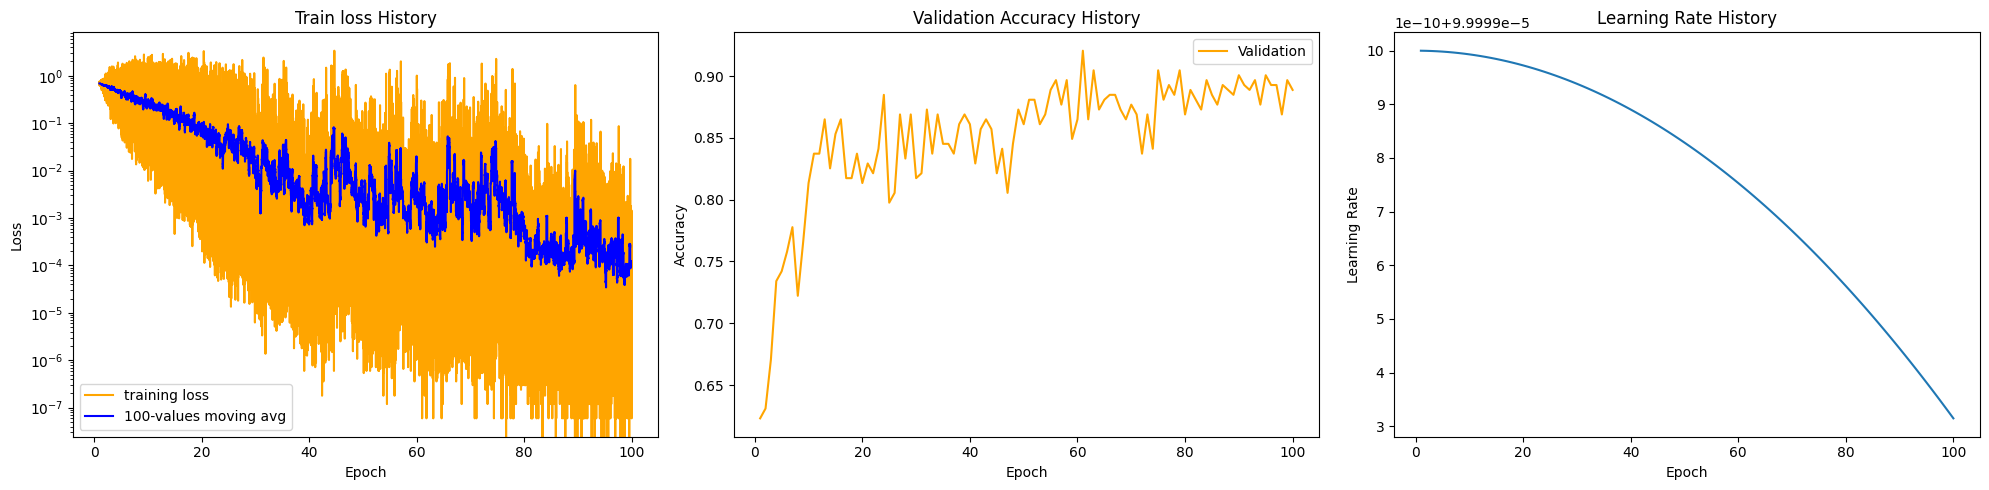

In [47]:
accuracy_history=acc_history_test.copy()
loss_history=loss_history_test
train_loss = loss_history_train.copy()

# Use numpy's convolve function to calculate the moving average
moving_avg_train = np.convolve(train_loss, np.ones(100)/100, mode='valid')
#print(len(train_loss))
#print(len(moving_avg_train))

n_train = len(accuracy_history)

t_test = np.arange(1, num_epochs + 1)
t_train = np.linspace(1,num_epochs,len(loss_history_train))

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting training loss history
axs[0].semilogy(t_train, train_loss, color='orange', label="training loss")
axs[0].semilogy((t_train[:-99]), moving_avg_train, color='blue', label="100-values moving avg")
axs[0].legend()
axs[0].set_title('Train loss History')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(t_test, accuracy_history, label="Validation", color='orange')
axs[1].set_title('Validation Accuracy History')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(t_test, lr_history_train)
axs[2].set_title('Learning Rate History')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')

plt.tight_layout()
plt.show()


In [44]:
@torch.no_grad()
def compute_f1(model, device, test_loader):
    model.eval()
    batch_f1 = np.zeros(len(test_loader))

    for batch_idx, (data, target) in enumerate(test_loader):    # iterate over each minibatch
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)

        batch_f1[batch_idx] = multiclass_f1_score(pred, target, num_classes=2)   # compute the F1 score for 1 minibatch

    f1_score = np.sum(batch_f1) / len(test_loader)  # Output is the average of the f1 score over all minibatches

    return f1_score

In [45]:
best_idx = np.argmax(accuracy_history)

print(f"The best validation accuracy was obtained on epoch {t_test[best_idx]} and was {accuracy_history[best_idx]*100:.2f} %. \n ")
print(f"The F1-score of this model is {compute_f1(model, device, test_loader)}. ")


The best validation accuracy was obtained on epoch 61 and was 92.06 %. 
 
The F1-score of this model is 0.9153846153846154. 


## 7. Debugging tools

### a) Confusion matrix

predictions:  [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

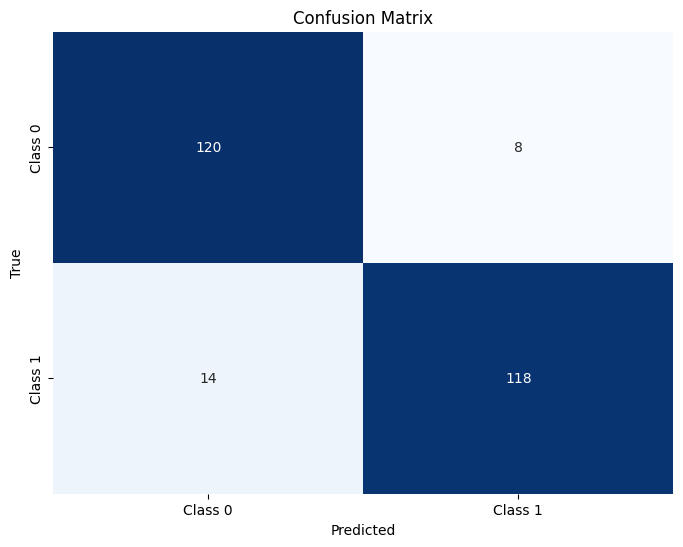

In [41]:
# Convert PyTorch tensors to NumPy arrays
model.eval()
predictions = []
labels = []
model = model.to(device)

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)
  pred = pred.cpu().numpy()
  target = target.cpu().numpy()
  target = np.array([t.item() for t in target], dtype=float)
  target = np.array(target, dtype=float)
  predictions.extend(pred)
  labels.extend(target)

print("predictions: ", predictions)
print("labels: ", labels)


# Compute confusion matrix using scikit-learn
cm = confusion_matrix(labels, predictions)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### b) Visualize misclassified images

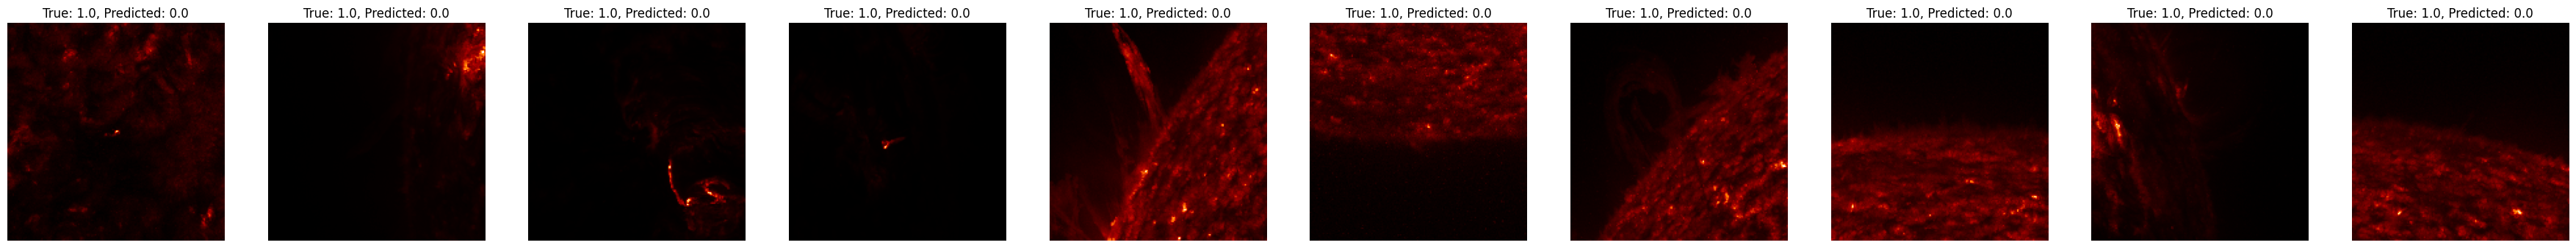

In [42]:
# Set the model to evaluation mode
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

misclassified_images = []
true_labels = []
predicted_labels = []

# Iterate through the test set
for data, target in test_loader:
    # Forward pass
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)

    # Identify misclassified images
    misclassified_mask = pred != target
    misclassified_images.extend(data[misclassified_mask])
    true_labels.extend(target[misclassified_mask])
    predicted_labels.extend(pred[misclassified_mask])

# Convert lists to PyTorch tensors
misclassified_images = torch.stack(misclassified_images)
true_labels = torch.stack(true_labels)
predicted_labels = torch.stack(predicted_labels)

# Assuming you have a function to reverse normalization if applied during data preprocessing
# Replace reverse_normalize with your actual function
# Example:
reverse_normalize = transforms.Compose([transforms.Normalize(mean=0, std=(1/62.7087)),
                                        transforms.Normalize(mean=-51.6644, std=1)])

# Display misclassified images
num_images_to_display = min(10, len(misclassified_images))
fig, axes = plt.subplots(1, num_images_to_display, figsize=(45,6))

for i in range(num_images_to_display):
    # Assuming images are in RGB format
    image = reverse_normalize(misclassified_images[i]).cpu().numpy()
    true_label = true_labels[i].item()
    predicted_label = predicted_labels[i].item()

    axes[i].imshow(image[15,:,:], cmap='sdoaia304')
    axes[i].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[i].axis('off')

plt.show()
